In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [18]:
from experiments import SensorPlacement
from experiments import utilities as utils
from bayesinverse import Regression

In [19]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/sensor_placement/config.yaml"
)

exp = SensorPlacement(config_path)


In [20]:
exp.K = exp.transport.get_transport(
    exp.sensors, exp.emissions
)


In [21]:
n_mc = 1000

n_sample_list = [5, 10, 15, 20, 25]
information_dict = {}
dof_dict = {}
for n_sample in n_sample_list:
    print(n_sample)
    information_dict[n_sample] = []
    dof_dict[n_sample] = []
    for i in range(n_mc):
        sensor_ids = exp.sensors.get_sample_ids(n_sample)

        reg = Regression(
            y=utils.stack_xr(
                exp.K.isel(sensor=sensor_ids) @ exp.emissions.truth
                + exp.sensors.get_noise(n_sample)
            ).values,
            K=utils.stack_xr(exp.K.isel(sensor=sensor_ids)).values,
            x_prior=utils.stack_xr(exp.emissions.prior).values,
            x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
            y_covariance=utils.stack_xr(
                exp.sensors.get_covariance().isel(sensor=sensor_ids)
            ).values,
        )
        information_dict[n_sample].append(reg.get_information_content())
        dof_dict[n_sample].append(reg.get_dof_signal())


5
10
15
20
25


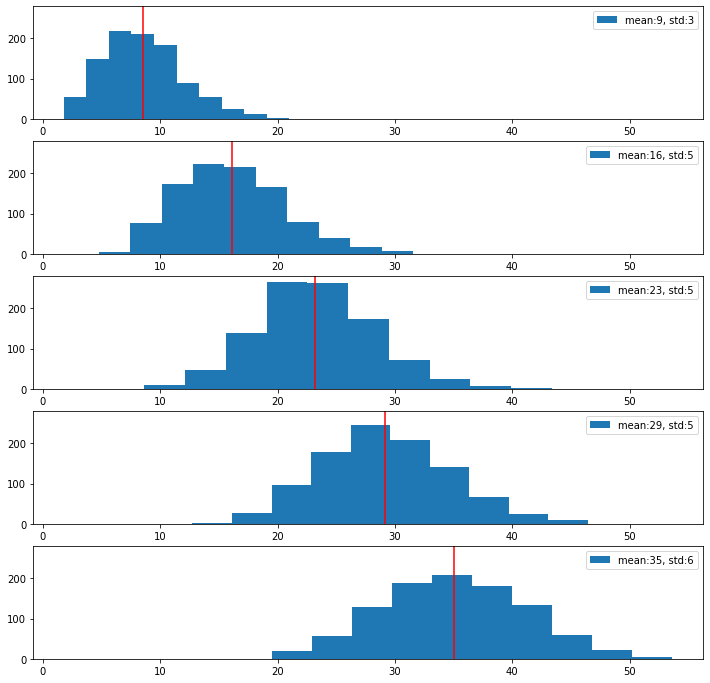

In [42]:
fig, axs = plt.subplots(len(n_sample_list), 1, figsize=(12, 12))
for i, n_sample in enumerate(n_sample_list):
    ax = axs[i]
    data = np.array(information_dict[n_sample])

    _ = ax.hist(data, label="mean:{:.0f}, std:{:.0f}".format(data.mean(), data.std()))
    ax.legend()
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    
for i, n_sample in enumerate(n_sample_list):
    ax = axs[i]
    data = np.array(information_dict[n_sample])
    
    ax.set_ylim(ax.get_ylim())
    ax.vlines(data.mean(), 0, 500, colors=["r"])

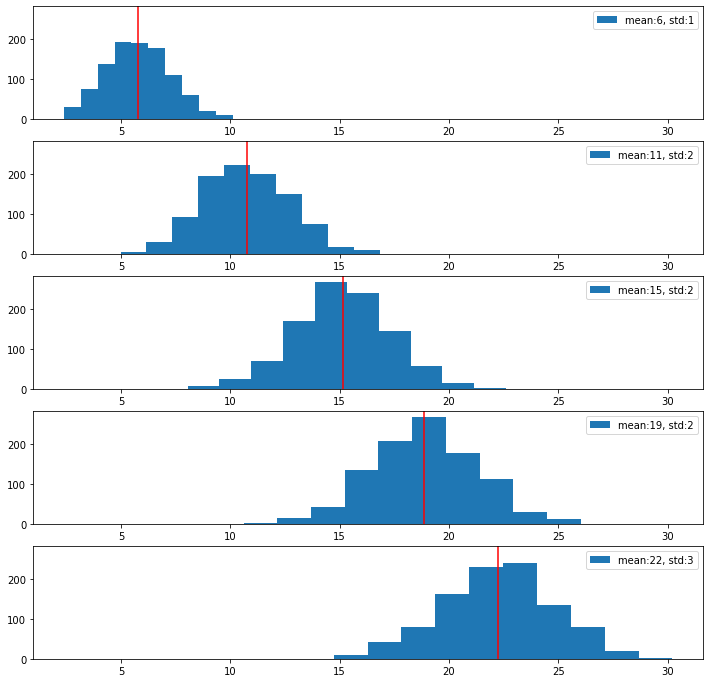

In [43]:
fig, axs = plt.subplots(len(n_sample_list), 1, figsize=(12, 12))
for i, n_sample in enumerate(n_sample_list):
    ax = axs[i]
    data = np.array(dof_dict[n_sample])

    _ = ax.hist(data, label="mean:{:.0f}, std:{:.0f}".format(data.mean(), data.std()))
    ax.legend()
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    
for i, n_sample in enumerate(n_sample_list):
    ax = axs[i]
    data = np.array(dof_dict[n_sample])
    
    ax.set_ylim(ax.get_ylim())
    ax.vlines(data.mean(), 0, 500, colors=["r"])